<a href="https://colab.research.google.com/github/thirtysmilesaday/CV/blob/master/DSF_talk_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (1) Importing Necessary Libraries

This section of the code brings in the tools needed to perform web scraping, data manipulation, and interaction with Google services.

In [ ]:
# --- Initial Setup: Installations and Imports ---
# This cell installs all necessary libraries and imports them

print("--- Installing Libraries ---")
!pip install requests beautifulsoup4 pandas gspread google-colab google-auth apify-client numpy scikit-learn matplotlib seaborn spacy

print("\n--- Downloading spaCy English Model ---")
# Download a small English model for spaCy
!python -m spacy download en_core_web_sm


print("\n--- Importing Libraries ---")
# Standard Libraries
import re
import collections # Used in entity extraction

# Web Scraping Libraries
import requests
from bs4 import BeautifulSoup

# Data Manipulation and Analysis Libraries
import pandas as pd
import numpy as np

# Google Colab and Google Services Libraries
from google.colab import drive
from google.colab import auth
from google.colab import userdata # For accessing Colab secrets
from google.auth.transport.requests import AuthorizedSession
from google.auth import default
import gspread # For Google Sheets interaction

# Apify Client
from apify_client import ApifyClient

# Machine Learning Libraries (from scikit-learn)
from sklearn.feature_extraction.text import TfidfVectorizer # For text vectorization
from sklearn.cluster import KMeans # For clustering
from sklearn.decomposition import NMF # For NMF topic modeling
from sklearn.decomposition import TruncatedSVD as EntitySVD # For SVD on entity matrix (aliased)
# Potentially needed for SVD on main TF-IDF matrix visualization (if you add it back)
# from sklearn.decomposition import TruncatedSVD

# Natural Language Processing Libraries
import spacy # For Named Entity Recognition (NER)

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# IPython Display for Colab
from IPython import get_ipython
from IPython.display import display

print("\n--- Authenticating to Google ---")
auth.authenticate_user()
print("Authentication successful.")

print("\n--- Mounting Google Drive ---")
drive.mount('/content/drive')
print("Google Drive mounted.")

print("--- Setup Complete ---")

# You might also add initial DataFrame loading here if your data source is static
data_science_roles_df = pd.read_csv('path/to/your/data.csv') # Example
print(f"\nLoaded data_science_roles_df with shape: {data_science_roles_df.shape}")

# **(2) Investigating the DSF homepage structure and scraping links to all speaker profile pages**

This cell collects the urls to each speaker's page on the DSF website

To define your data extraction strategy, you first need to look at the structure of the webpages, where the information is hosted.
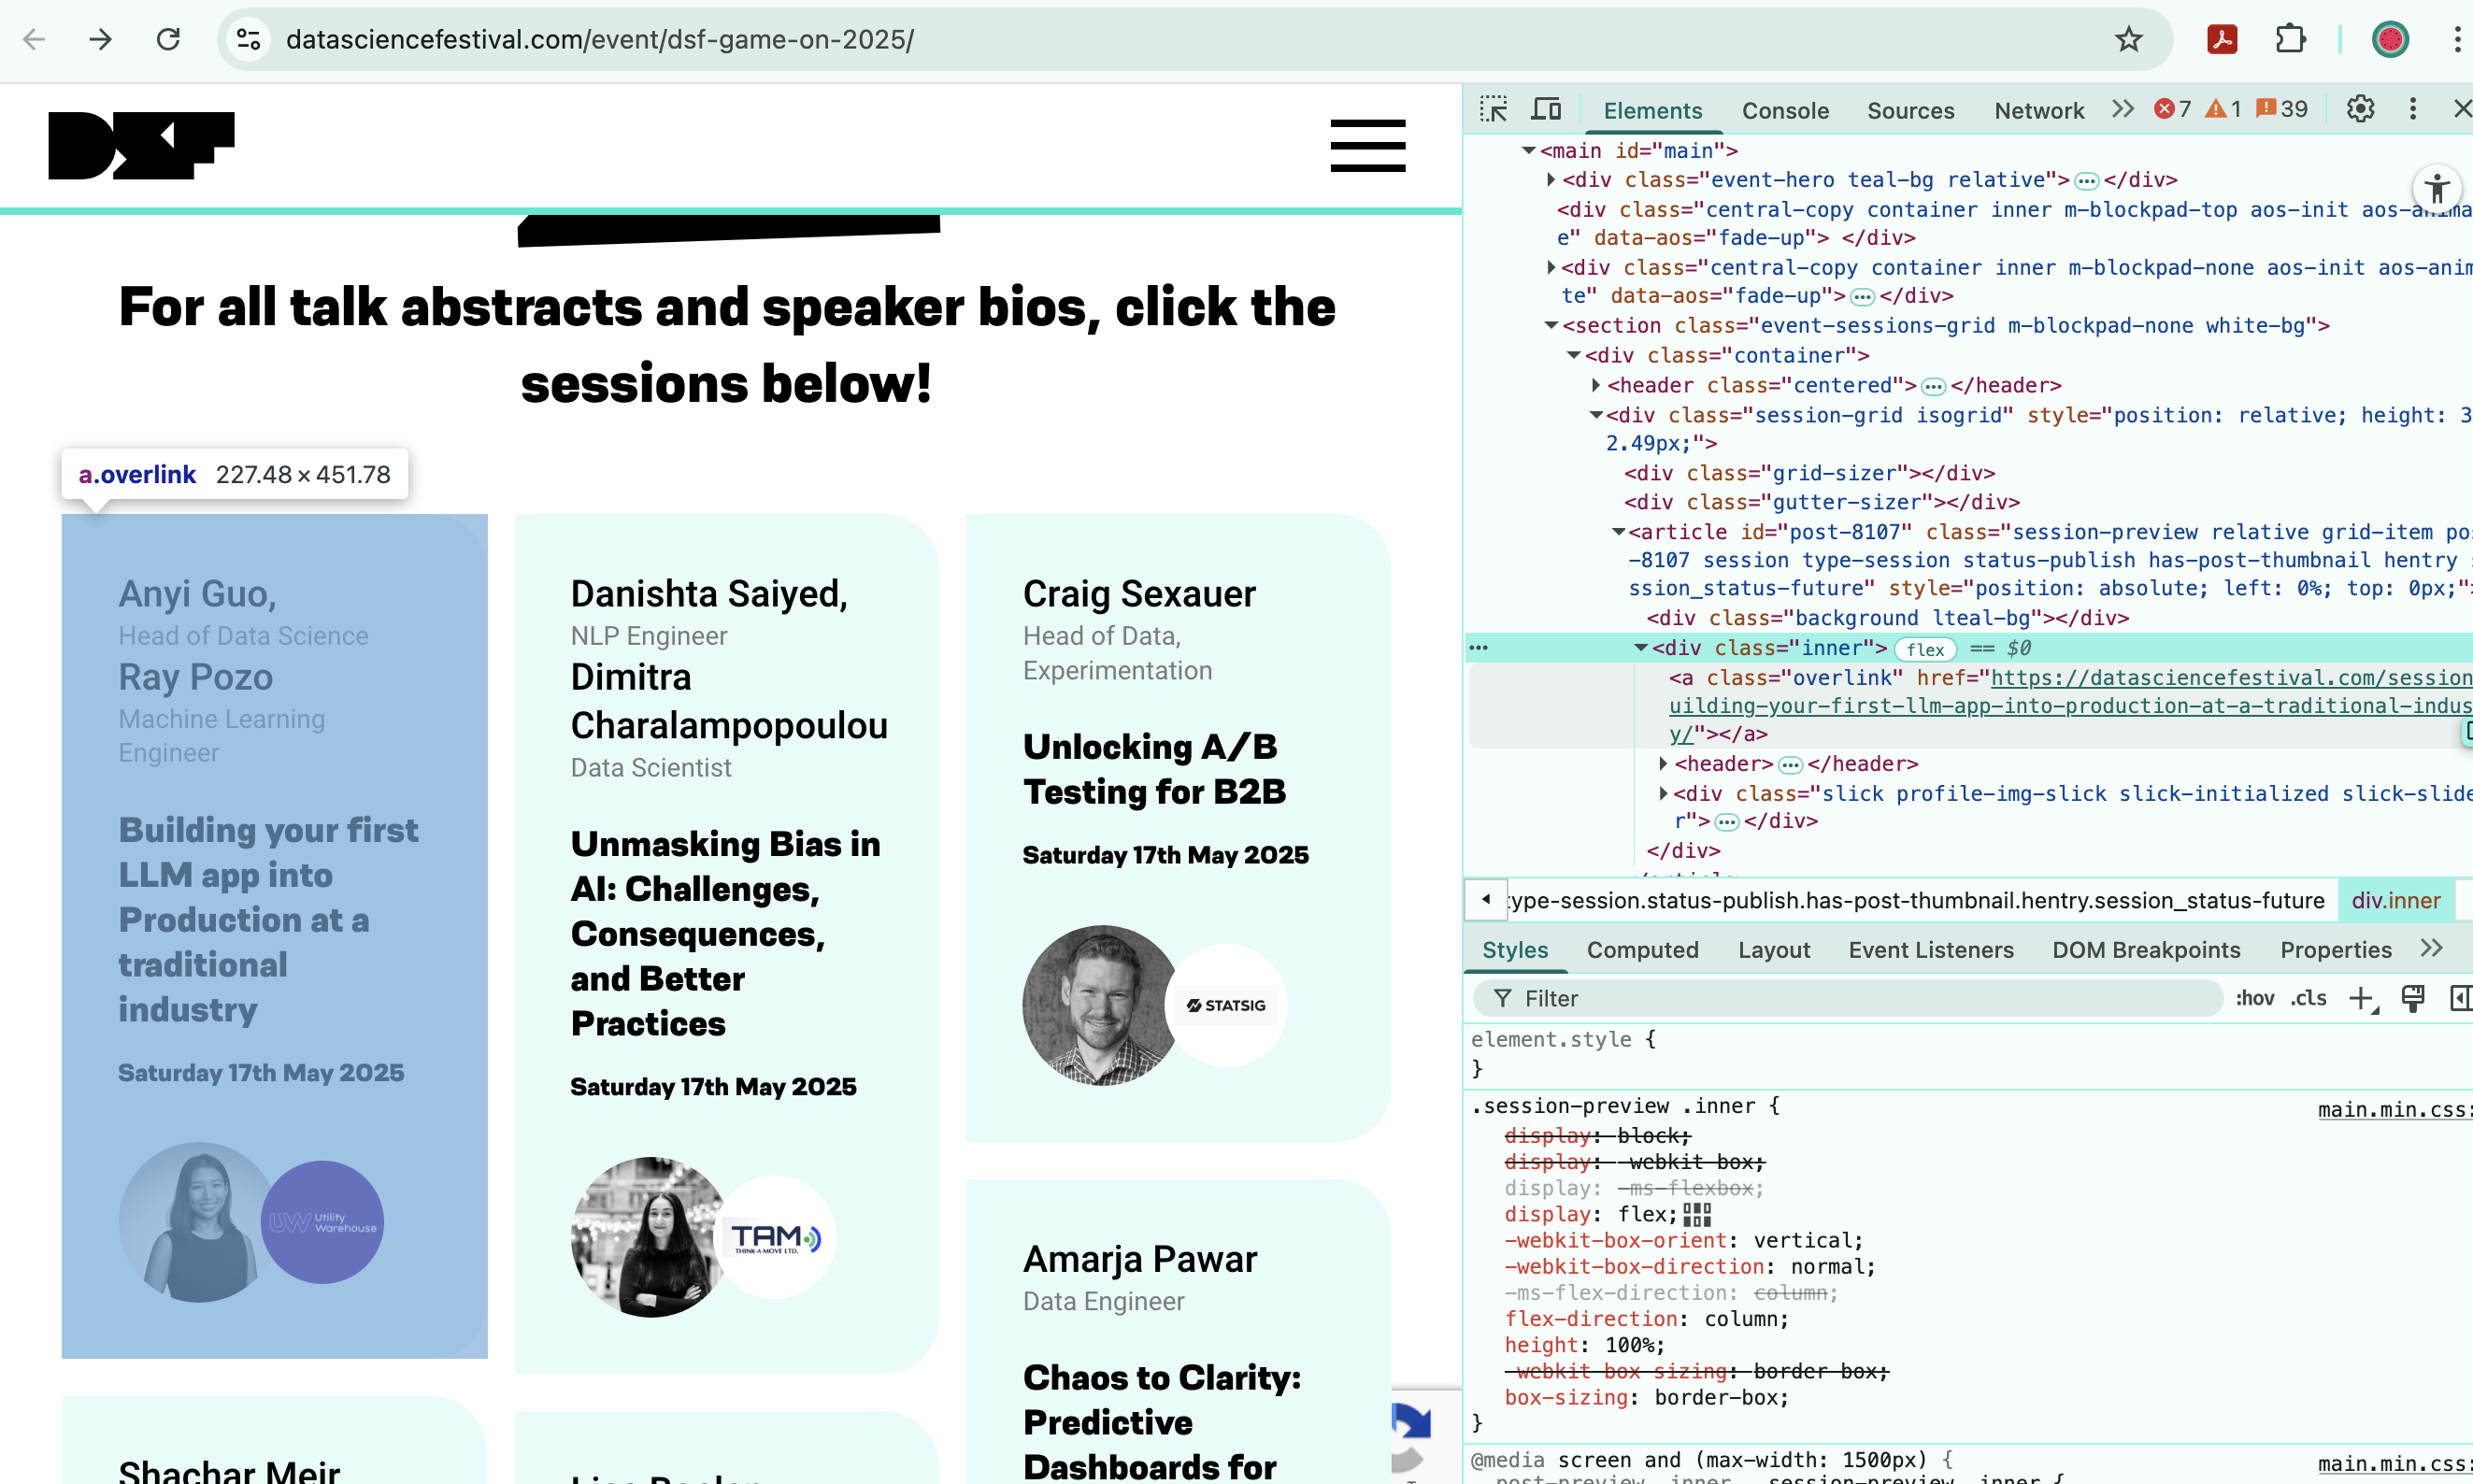

In [ ]:
# Define the source URL
source_url = "https://datasciencefestival.com/event/dsf-game-on-2025/"
urls_final = [] # Initialize an empty list to store the scraped URLs

print(f"Scraping speaker URLs from: {source_url}")

try:
    response = requests.get(source_url)
    response.raise_for_status()  # Raise an exception for bad status codes
    soup = BeautifulSoup(response.text, 'html.parser')

# --- Code to find the speaker profile URLs ---
# find all "href" in page and collect all urls which have "speaker" in their string
# replace "speaker" for another consistent label in code below...

    filtered_links = [a.get('href') for a in soup.find_all('a') if 'speaker' in a.get('href', '')]

# Extract the href attribute from each found link

    urls_final = list(dict.fromkeys(filtered_links))
    urls_final = list(filter(None, urls_final))


    print(f"Found {len(urls_final)} speaker URLs.")

# --- Save the scraped URLs to a CSV file ---
    df_urls = pd.DataFrame(urls_final, columns=['Speaker URL'])
    df_urls.to_csv('dsf_speaker_urls.csv', index=False)
    print("Scraped URLs saved to dsf_speaker_urls.csv")
# --- End Save to CSV ---


except requests.exceptions.RequestException as e:
    print(f"Error during initial scraping of {source_url}: {e}")
# urls_final remains an empty list if scraping fails

# urls_final and source_url are now defined for the next steps

Scraping speaker URLs from: https://datasciencefestival.com/event/dsf-game-on-2025/
Found 33 speaker URLs.
Scraped URLs saved to dsf_speaker_urls.csv


# Collecting the indidual speaker details from their DSF pages

> this cell extracts the speaker data and inserts it into a google sheet tab



In [ ]:
# --- Your function definitions (extract_speaker_data, get_linkedin_name, main, format_company_url) go here ---
# Copy and paste the function definitions from your original first cell here.
# Make sure the 'main' function correctly uses the 'urls' parameter.

def extract_speaker_data(soup, source_url):
    """Extracts speaker data from a BeautifulSoup object."""
    try:
        speaker_name = soup.find('h1').text.strip()
        speaker_profile = None
        content_div = soup.find('div', class_='col m-blockpad post-content')
        if content_div:
            p_tags = content_div.find_all('p')
            if p_tags:
                speaker_profile = "\n".join([p.text.strip() for p in p_tags])
        job_title_element = soup.find('span', class_='position')
        job_title = job_title_element.text.strip() if job_title_element else None
        linkedin_url = None
        social_links_ul = soup.find('ul', class_='social-links')
        if social_links_ul:
            linkedin_link = social_links_ul.find('a', {'href': lambda href: href and 'linkedin.com/in/' in href})
            if linkedin_link:
                linkedin_url = linkedin_link['href']
        return speaker_name, speaker_profile, linkedin_url, job_title, source_url
    except Exception as e:
        print(f"Error extracting data from {source_url}: {e}")
        return None, None, None, None, source_url

def get_linkedin_name(linkedin_url):
    """Extracts the LinkedIn name from the LinkedIn URL."""
    if linkedin_url:
        try:
            ln_index = linkedin_url.index("in/")
            linkedin_name = linkedin_url[ln_index + 3:]
            linkedin_name = linkedin_name.split('/')[0]
            return linkedin_name
        except ValueError:
            print(f"Invalid LinkedIn URL format: {linkedin_url}")
            return None
    else:
        return None

def main(urls, source_url):
    """Main function to process URLs and extract speaker data."""
    data = []
    for url in urls:
        print(f"Processing URL: {url}")
        try:
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')
            speaker_data = extract_speaker_data(soup, source_url)
            data.append(speaker_data)
        except requests.exceptions.RequestException as e:
            print(f"Error processing URL {url}: {e}")
            data.append([None, None, None, None, source_url])
    df = pd.DataFrame(data, columns=['Speaker Name', 'Speaker Profile', 'LinkedIn URL', 'Job Title', 'Source URL'])
    df['LinkedIn Name'] = df['LinkedIn URL'].apply(get_linkedin_name)
    return df

def format_company_url(url):
    """Formats a potential company URL to a standard LinkedIn company URL."""
    if pd.isna(url):
        return None
    url_str = str(url)
    if re.match(r'^https?://(www\.)?linkedin\.com/company/', url_str):
        return url_str
    if url_str.startswith('/company/'):
         return f'https://www.linkedin.com{url_str}'
    elif re.match(r'^\d+$|^[a-zA-Z0-9_-]+$', url_str):
        return f'https://www.linkedin.com/company/{url_str}/'
    return None

# Install gspread and google-auth
!pip install gspread google-auth

# Authenticate with Google
auth.authenticate_user()

# Get credentials using google-auth
credentials, project = default()

# Authorize gspread with the google-auth credentials
authorized_session = AuthorizedSession(credentials)
gs = gspread.client.Client(auth=credentials)

# Define the title of your Google Sheet
sheet_title = 'DSF Speaker and Company Data'

try:
    sh = gs.open(sheet_title)
    print(f"Successfully opened Google Sheet: {sheet_title}")
except gspread.SpreadsheetNotFound:
    print(f"Google Sheet '{sheet_title}' not found. Creating a new one...")
    sh = gs.create(sheet_title)
    print(f"Created new Google Sheet: {sheet_title}")

# --- Call the main function using urls_final and source_url defined in the previous cell ---
df = main(urls_final, source_url)

# Save df to 'Speaker Data' tab
try:
    worksheet = sh.worksheet('Speaker Data')
except gspread.WorksheetNotFound:
    worksheet = sh.add_worksheet(title="Speaker Data", rows="1", cols="1")

worksheet.clear()
worksheet.update([df.columns.tolist()] + df.values.tolist())
print("df (Speaker Data) saved to Google Sheet tab 'Speaker Data'.")

# Note: df_companies will be created in the next block (Apify Profile Scraping)

Successfully opened Google Sheet: DSF Speaker and Company Data
Processing URL: https://datasciencefestival.com/speaker/craig-sexauer/
Processing URL: https://datasciencefestival.com/speaker/amarja-pawar/
Processing URL: https://datasciencefestival.com/speaker/lies-boelen/
Processing URL: https://datasciencefestival.com/speaker/jerry-mundondo/
Processing URL: https://datasciencefestival.com/speaker/shachar-meir/
Processing URL: https://datasciencefestival.com/speaker/aurora-kapo/
Processing URL: https://datasciencefestival.com/speaker/anna-vissens/
Processing URL: https://datasciencefestival.com/speaker/lorenzo-greco/
Processing URL: https://datasciencefestival.com/speaker/ali-parandeh/
Processing URL: https://datasciencefestival.com/speaker/james-dsouza/
Processing URL: https://datasciencefestival.com/speaker/daria-meshcherina/
Processing URL: https://datasciencefestival.com/speaker/aurora-moreno-herrera/
Processing URL: https://datasciencefestival.com/speaker/georgios-giasemidis/
Proc

# Using the LinkedIn names to compile the collective job history for further analysis

This section of the code focuses on using the Apify platform to scrape additional data from the LinkedIn profiles that were previously identified and stored in the df DataFrame. The goal is to get detailed information about each speaker's work history, particularly their current and full-time roles, and then organize this information into a separate DataFrame for further analysis and saving to a Google Sheet.

In [ ]:
# Initialize the ApifyClient with your Apify API token
# Insert '<YOUR_API_TOKEN>' into this scripts secret keys


apify_token = userdata.get('apify')

client = ApifyClient(apify_token)


# Prepare the Actor input (for LinkedIn Profile Scraper)
# Use the 'LinkedIn URL' column from your DataFrame as the usernames
# Filter out None values in case some URLs were not extracted
linkedin_usernames = df['LinkedIn URL'].dropna().tolist()

run_input_profiles = { "usernames": linkedin_usernames }

# Run the LinkedIn Profile Scraper Actor and wait for it to finish
print("Running LinkedIn Profile Scraper...")
run_profiles = client.actor("apimaestro/linkedin-profile-batch-scraper-no-cookies-required").call(run_input=run_input_profiles)
print("LinkedIn Profile Scraper run finished.")


# Fetch and process Actor results from the run's dataset (LinkedIn Profile Scraper)
print("💾 Check the full profile data here: https://console.apify.com/storage/datasets/" + run_profiles["defaultDatasetId"])

# List to store processed data for each profile (optional for main df)
processed_profile_data = []

# List to store company data for the new DataFrame (used for visualization)
company_data_list = []

for item in client.dataset(run_profiles["defaultDatasetId"]).iterate_items():
    # Initialize all_companies for the current profile (optional, for main df)
    all_companies = []

    # Extract the desired fields
    profile_url = item.get('profileUrl')

    basic_info = item.get('basic_info', {})
    headline = basic_info.get('headline')
    follower_count = basic_info.get('follower_count')
    connection_count = basic_info.get('connection_count')
    current_company = basic_info.get('current_company')
    current_company_url = basic_info.get('current_company_url')


     # Add current company data to the list for the company DataFrame (always included)
    if current_company:
        # Ensure start_date exists before attempting calculation
        start_year_current = basic_info.get('start_date', {}).get('year')
        # Calculate duration. Handle cases where start_year_current might be None or invalid
        try:
            start_year_current_int = int(start_year_current) if start_year_current is not None else None
            duration_current = (pd.to_datetime('now').year - start_year_current_int) if start_year_current_int is not None else None
        except (ValueError, TypeError):
             duration_current = None # Handle cases where year is not a valid number


        company_data_list.append({
            'profileUrl': profile_url,
            'company_name': current_company,
            'company_url': current_company_url,
            'experience_title': None,
            'experience_start_year': start_year_current, # Keep original format for sheet
            'experience_end_year': None,
             # Use the calculated duration, which is None if calculation failed
            'experience_duration_years': duration_current,
            'employment_type': 'Current'
        })
        # all_companies.append(current_company) # Optional: add to all_companies list


    experiences = item.get('experience', [])
    processed_experiences = [] # Optional: for main df

    for exp in experiences:
        employment_type = exp.get('employment_type')

        # --- Filter for Full-time roles ---
        # Also process roles where employment_type is None or missing, but have start/end dates
        if employment_type == 'Full-time' or (employment_type is None and exp.get('start_date') and exp.get('end_date')):
        # --- End of Filter ---
            start_year = exp.get('start_date', {}).get('year')
            end_year = exp.get('end_date', {}).get('year')

            # Calculate duration in years
            duration_years = None
            try:
                start_year_int = int(start_year) if start_year is not None else None
                end_year_int = int(end_year) if end_year is not None else None

                if start_year_int is not None:
                    if end_year_int is not None:
                        duration_years = end_year_int - start_year_int
                    # Removed the 'current year' calculation for past roles
                    # as it was redundant with the current role handling above
            except (ValueError, TypeError):
                duration_years = None # Handle cases where year is not a valid number


            company_name = exp.get('company')
            company_linkedin_url = exp.get('company_linkedin_url')


            if company_name:
                # Add experience company data to the list for the company DataFrame
                company_data_list.append({
                    'profileUrl': profile_url,
                    'company_name': company_name,
                    'company_url': company_linkedin_url,
                    'experience_title': exp.get('title'),
                    'experience_start_year': start_year, # Keep original format for sheet
                    'experience_end_year': end_year,     # Keep original format for sheet
                    # Use the calculated duration, which is None if calculation failed
                    'experience_duration_years': duration_years,
                    'employment_type': employment_type if employment_type else 'Unknown/Other' # Label if employment_type was None
                })
                # all_companies.append(company_name) # Optional: add to all_companies list


            # Optional: Structure processed experience for main df
            # processed_experience = { ... }
            # processed_experiences.append(processed_experience)


    education = item.get('education', []) # Optional: for main df
    # processed_education = []
    # for edu in education: ...


    languages = item.get('languages', []) # Optional: for main df
    # processed_languages = []
    # for lang in languages: ...


    # Optional: Structure processed data for the main profile DataFrame
    # processed_item = { ... }
    # processed_profile_data.append(processed_item)


# Create the DataFrame of Companies (including current and full-time experience) for visualization and company scraping
df_companies = pd.DataFrame(company_data_list, columns=[
      'profileUrl',
      'company_name',
      'company_url',
      'experience_title',
      'experience_start_year',
      'experience_end_year',
      'experience_duration_years',
      'employment_type'
  ])

# --- Enhanced NaN/Inf handling before sending to Google Sheets ---
# Iterate through columns that might contain numerical or special values
for col in ['experience_start_year', 'experience_end_year', 'experience_duration_years']:
    if col in df_companies.columns:
        # Replace numpy NaN/Inf with None
        df_companies[col] = df_companies[col].replace([np.inf, -np.inf], np.nan)
        # Convert pandas NaN (float) to Python None for JSON compatibility
        df_companies[col] = df_companies[col].apply(lambda x: None if pd.isna(x) else x)

# Ensure other potential numerical columns are also handled if added later
# For safety, you could apply a general cleaning function to all columns
# def clean_for_json(value):
#     if isinstance(value, float) and (np.isnan(value) or np.isinf(value)):
#         return None
#     return value

# df_companies = df_companies.applymap(clean_for_json)
# --- End Enhanced NaN/Inf handling ---


# You can now print or work with df_companies
#print("\nDataFrame of Companies (including current and full-time experience):")
#print(df_companies)

# Optional: You can still have the main processed_profile_data as a DataFrame if needed
# df_profiles = pd.DataFrame(processed_profile_data)
# print("\nMain Profile DataFrame (includes lists):")
# print(df_profiles)

# Save df to 'LinkedIn Company' tab
try:
      worksheet = sh.worksheet('LinkedInCompanies')
except gspread.WorksheetNotFound:
      worksheet = sh.add_worksheet(title="LinkedInCompanies", rows="1", cols="1")

worksheet.clear()

# --- Add explicit handling of NaN/Inf before converting to list ---
# Replace all remaining NaN/Inf values with None before sending to Google Sheets
# This acts as a final safeguard before JSON serialization.
df_companies_cleaned = df_companies.replace([np.nan, np.inf, -np.inf], None)

# When updating to Google Sheets, gspread handles None correctly for blank cells
# Converting to values.tolist() creates a list of lists which gspread expects
worksheet.update([df_companies_cleaned.columns.tolist()] + df_companies_cleaned.values.tolist())
# --- End Add explicit handling ---

print("df_companies saved to Google Sheet tab 'LinkedInCompanies'.")

Running LinkedIn Profile Scraper...


ApifyApiError: By launching this job you will exceed your remaining usage of $0.002832.  Please consider upgrading to a paid plan at https://console.apify.com/billing/subscription

# Exploring the collected information

In [ ]:
# Explore the df (Speaker Data) DataFrame

print("\nInformation about df (data types and non-null counts):")
print(df.info())

# Replace 'Job Title Column' with the actual name of the column
# that contains the job titles in your DataFrame
job_title_counts = df['Job Title'].value_counts()

print("Count of each current job title:")
print(job_title_counts)


Information about df (data types and non-null counts):


NameError: name 'df' is not defined

reviewing the different types of job titles I'm interested to understand a bit more about the bredth of industry and experience Data Scientists speaking at the Data Science Festival have, so I create a group...and add their speaker profile

# Filtering df for Data Science Job titles

In [ ]:

job_title_column = 'Job Title'
profile_text_column = 'Speaker Profile'


# Check if required columns exist
if job_title_column not in df.columns:
    print(f"Error: Job title column '{job_title_column}' not found in df. Cannot proceed with filtering.")
elif profile_text_column not in df.columns:
     print(f"Warning: Speaker profile text column '{profile_text_column}' not found in df.")
else:
    data_science_roles_df = df[df[job_title_column].str.contains(
        'data scien', # String to search for
        na=False,     # Treat NaN values as False (don't include rows with missing job titles)
        case=False    # Perform case-insensitive matching
    )].copy() # Use .copy() to ensure this is a new DataFrame

    # Display a sample, ensuring the relevant columns are shown if they exist
    display_cols = [job_title_column, profile_text_column]
    existing_display_cols = [col for col in display_cols if col in data_science_roles_df.columns]

    if existing_display_cols:
        print(f"\nFirst 5 rows of data_science_roles_df (showing {existing_display_cols}):")
        print(data_science_roles_df[existing_display_cols].head())
    elif not data_science_roles_df.empty:
         print("\nFiltered DataFrame created, but specified display columns are missing.")
         print("Columns in filtered DataFrame:", data_science_roles_df.columns.tolist())
    else:
         print("\nFiltered DataFrame is empty.")

NameError: name 'df' is not defined

In [ ]:
#print(data_science_roles_df)
print(data_science_roles_df.info())

NameError: name 'data_science_roles_df' is not defined

Need to remove Speaker's names from their profiles....

Techniques for "Biggest Information Gain" in Your Context:

Considering you have speaker profiles for a Data Science Festival, the techniques offering the most relevant information gain are likely:

Named Entity Recognition (NER): To identify specific technologies, tools, frameworks, companies, research areas, or even specific events mentioned. This gives you concrete data points about expertise.
Keyword Extraction / Topic Modeling: To identify the dominant themes and areas of focus within data science that your speakers cover (e.g., "Machine Learning", "Deep Learning", "Big Data", "NLP", "Computer Vision", "Ethics in AI"). This helps you understand the breadth and depth of topics at the festival.
Text Vectorization + Clustering: To group speakers with similar expertise based on the nuances in their profile text, revealing sub-communities or specialized groups of speakers.
How to Start:

Before applying complex techniques, start with:

Preprocessing: Clean the text (lowercase, remove punctuation, remove stop words, potentially stemming or lemmatization).
Simple Word Frequency: Just count words (after removing stop words) to see the most common terms. This gives you a quick initial feel for the content.
Manual Review: Read through a few profiles to get a qualitative understanding of the kind of information they contain and how it's phrased. This will guide your choice of more advanced techniques and help you refine your text extraction strategy.

# Text Vectorization

In [ ]:
!pip install scikit-learn nltk # Ensure scikit-learn is installed for vectorization, nltk for stop words

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk # Import nltk for stop words

# --- Download standard English stop words ---
# This block checks if the resource is available and downloads it if not.
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK stopwords resource found.")
except LookupError:
    print("NLTK stopwords resource not found. Downloading...")
    # Download the stopwords resource
    nltk.download('stopwords')
    print("NLTK stopwords download complete.")

from nltk.corpus import stopwords # Import stopwords corpus after potential download


# --- Configuration for TF-IDF ---
# Column containing the text to vectorize
profile_text_column = 'Speaker Profile' # <-- Ensure this is correct
speaker_name_column = 'Speaker Name' # <-- Ensure this is correct and exists
# You might have other configurations like max_features, stop_words, ngram_range, etc.
custom_stop_words_list = ['science', 'data', 'driven']
# --- End Configuration ---

# Combine default English stop words with your custom list
# Get the default English stop words from a temporary vectorizer
# You could also hardcode a list, but this uses scikit-learn's internal list
temp_vectorizer = TfidfVectorizer(stop_words='english')
default_english_stop_words = list(temp_vectorizer.get_stop_words())

# Combine the lists and remove duplicates
all_stop_words = list(set(default_english_stop_words + custom_stop_words_list))


# Ensure the required columns exist
if profile_text_column not in data_science_roles_df.columns:
    print(f"Error: Text column '{profile_text_column}' not found in data_science_roles_df.")
elif speaker_name_column not in data_science_roles_df.columns:
     print(f"Error: Speaker name column '{speaker_name_column}' not found in data_science_roles_df.")
else:
    print(f"\n--- Preparing text by removing speaker names and Performing TF-IDF Vectorization on '{profile_text_column}' ---")

    # --- Step 1: Remove Speaker Name from Profile Text ---
    # Handle potential missing values in both columns
    profiles = data_science_roles_df[profile_text_column].fillna('').astype(str)
    speaker_names = data_science_roles_df[speaker_name_column].fillna('').astype(str)

    # Create a new series or list with names removed
    # We'll iterate through each profile and replace the name if found
    texts_cleaned = []
    for profile, name in zip(profiles, speaker_names):
        # Replace the name (case-insensitive) with an empty string
        # Using re.escape to handle special characters in names if any
        # Using word boundaries (\b) to avoid replacing parts of other words
        cleaned_profile = re.sub(r'\b' + re.escape(name) + r'\b', '', profile, flags=re.IGNORECASE)
        # You might also want to remove extra whitespace created by the replacement
        cleaned_profile = re.sub(r'\s+', ' ', cleaned_profile).strip()
        texts_cleaned.append(cleaned_profile)

    print("Speaker names removed from profile texts.")

    # --- Step 2: Apply TF-IDF to the cleaned texts ---
    # Use the cleaned texts for vectorization
    texts_to_vectorize = texts_cleaned

    vectorizer = TfidfVectorizer(
        max_features=1000,  # Example: Limit to top 1000 features
        stop_words='english' # Example: Remove common English stop words
        # Add any other parameters you were using here (ngram_range, etc.)
    )

    tfidf_matrix = vectorizer.fit_transform(texts_to_vectorize)

    print("TF-IDF vectorization complete on cleaned texts.")
    print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

    # Store the vectorizer and tfidf_matrix globally for subsequent cells
    globals()['vectorizer'] = vectorizer
    globals()['tfidf_matrix'] = tfidf_matrix

NLTK stopwords resource not found. Downloading...
NLTK stopwords download complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NameError: name 'data_science_roles_df' is not defined

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which is a widely used technique. It assigns a weight to each word in a document based on its frequency within that document and its rarity across all documents. This helps give more importance to words that are specific to a speaker's profile rather than common words that appear everywhere.

We'll use TfidfVectorizer from the scikit-learn library.

In [ ]:
# Assume tfidf_matrix and vectorizer were successfully created in the previous step

# --- Step 1: Explore the learned features (terms) ---
if vectorizer is not None: # Ensure vectorizer was created
    print("\n--- Exploring TF-IDF Features ---")
    feature_names = vectorizer.get_feature_names_out()
    print(f"Total number of features (terms): {len(feature_names)}")

    # Display some features (words/phrases) from the learned vocabulary
    print("\nSample features from the vocabulary:")
    print(feature_names[:20]) # Display the first 20 features
    print(feature_names[-20:]) # Display the last 20 features

    # You can also get the IDF scores for each term (Inverse Document Frequency)
    # Higher IDF means the term is rarer across documents, thus potentially more distinctive.
    # Note: Feature names and IDF scores are in the same order.
    idf_scores = vectorizer.idf_
    print("\nSample IDF scores (higher is more unique):")
    # Create a Series or DataFrame for easier viewing
    idf_df = pd.DataFrame({'feature': feature_names, 'idf': idf_scores})
    # Sort by IDF to see the most distinctive terms first
    idf_df_sorted = idf_df.sort_values(by='idf', ascending=False).reset_index(drop=True)
    print(idf_df_sorted.head(10))
    print("\nSample IDF scores (lower is more common):")
    print(idf_df_sorted.tail(10))

    # To see which terms are most frequent overall (though not necessarily most *distinctive* by TF-IDF)
    # Sum the TF-IDF scores for each feature across all documents
    if tfidf_matrix is not None: # Ensure tfidf_matrix was created
        # Summing TF-IDF scores across documents can give a proxy for overall importance/frequency
        tfidf_sums = tfidf_matrix.sum(axis=0)
        # Convert the sparse matrix sum to a dense array
        tfidf_sums_array = np.asarray(tfidf_sums).flatten()

        tfidf_sum_df = pd.DataFrame({'feature': feature_names, 'tfidf_sum': tfidf_sums_array})
        tfidf_sum_df_sorted = tfidf_sum_df.sort_values(by='tfidf_sum', ascending=False).reset_index(drop=True)

        print("\nTop 10 terms by sum of TF-IDF scores (overall importance):")
        print(tfidf_sum_df_sorted.head(10))

# --- Step 2: Dimensionality Reduction (e.g., using PCA or T-SNE) ---
# Dimensionality reduction is useful for visualization or reducing noise.
# Let's reduce to 2 or 3 components for potential plotting later.
# We'll use TruncatedSVD, which is suitable for sparse matrices like TF-IDF.

from sklearn.decomposition import TruncatedSVD

if tfidf_matrix is not None: # Ensure tfidf_matrix was created
    print("\n--- Performing Dimensionality Reduction (TruncatedSVD) ---")
    n_components = 50 # Choose a number of components smaller than the number of features
    if tfidf_matrix.shape[1] < n_components:
         n_components = tfidf_matrix.shape[1] # Ensure n_components is not more than features

    if n_components > 1: # Only perform SVD if there's more than 1 component
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        tfidf_reduced = svd.fit_transform(tfidf_matrix)

        print(f"Reduced TF-IDF matrix shape: {tfidf_reduced.shape}")
        print(f"Variance explained by the first {n_components} components: {svd.explained_variance_ratio_.sum():.4f}")

        # Store the reduced vectors in the DataFrame for later use (e.g., clustering, visualization)
        # You could store all components or just the first few
        for i in range(tfidf_reduced.shape[1]):
            data_science_roles_df[f'svd_{i+1}'] = tfidf_reduced[:, i]

        print(f"Added {tfidf_reduced.shape[1]} SVD components to data_science_roles_df.")
        print("Sample of data_science_roles_df with SVD components:")
        # Display original columns plus the new SVD columns
        print(data_science_roles_df[[job_title_column, profile_text_column] + [f'svd_{i+1}' for i in range(min(tfidf_reduced.shape[1], 3))]].head()) # Show first 3 SVD cols


    else:
        print("Cannot perform TruncatedSVD with 1 or fewer features.")
        tfidf_reduced = None # No reduced matrix if SVD wasn't performed


# --- Step 3: Explore Similarity (using cosine similarity) ---
# Cosine similarity measures the cosine of the angle between two vectors.
# A value of 1 means the vectors are identical, 0 means orthogonal (no similarity), -1 means opposite.

from sklearn.metrics.pairwise import cosine_similarity

if tfidf_matrix is not None: # Ensure tfidf_matrix was created
    print("\n--- Exploring Cosine Similarity ---")

    # Calculate the pairwise cosine similarity matrix between all speaker profiles
    print("Calculating pairwise cosine similarity...")
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    print(f"Cosine similarity matrix shape: {cosine_sim_matrix.shape}")

    # The diagonal is always 1 (a profile is identical to itself).
    # We can look at a few examples to see how similar profiles are to each other.
    # Let's find the most similar profiles for the first few speakers.

    num_examples_to_show = min(5, len(data_science_roles_df)) # Show examples for up to 5 speakers

    print(f"\nTop 3 most similar profiles for the first {num_examples_to_show} speakers:")
    for i in range(num_examples_to_show):
        # Get the similarity scores for speaker i with all other speakers
        sim_scores = list(enumerate(cosine_sim_matrix[i]))

        # Sort the scores in descending order (excluding similarity with itself)
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the indices and scores of the top 3 most similar profiles (after the first one, which is the speaker themselves)
        top_similar_indices = sim_scores_sorted[1:4] # Get the next 3 highest scores

        print(f"\nSpeaker {i+1} ('{data_science_roles_df.iloc[i]['Speaker Name'][:50]}...' if name column exists):") # Use speaker name if available
        # Assuming 'Speaker Name' is a column in your df
        if 'Speaker Name' in data_science_roles_df.columns:
             speaker_name = data_science_roles_df.iloc[i]['Speaker Name']
        else:
             speaker_name = f"Index {i}"

        print(f"Speaker {i+1} ({speaker_name}):")

        if not top_similar_indices:
            print("  No other similar profiles found.")
        else:
            for j, score in top_similar_indices:
                if 'Speaker Name' in data_science_roles_df.columns:
                    similar_speaker_name = data_science_roles_df.iloc[j]['Speaker Name']
                else:
                    similar_speaker_name = f"Index {j}"
                print(f"  - Speaker {j+1} ({similar_speaker_name}) with similarity score: {score:.4f}")

    # Optional: You could also save the similarity matrix or use it for specific lookups.
    # cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=data_science_roles_df.index, columns=data_science_roles_df.index)


# --- Next Steps: Clustering, Visualization ---
# Now that you have the tfidf_matrix and potentially the reduced tfidf_reduced matrix,
# you can proceed with:
# - Clustering: Apply a clustering algorithm (like K-Means, Agglomerative Clustering)
#               to the tfidf_matrix or tfidf_reduced to group similar speakers.
# - Visualization: Use the 2 or 3 components from dimensionality reduction (e.g., SVD, or t-SNE/UMAP
#                  applied *after* SVD/PCA) to plot speakers on a 2D/3D graph,
#                  potentially coloring points by job title or cluster.

NameError: name 'vectorizer' is not defined


--- Creating Network Diagram for Top 3 Similar Profiles ---
Adding edges for the top 3 similar profiles for the first 5 speakers...
Graph creation complete.

Drawing network diagram...


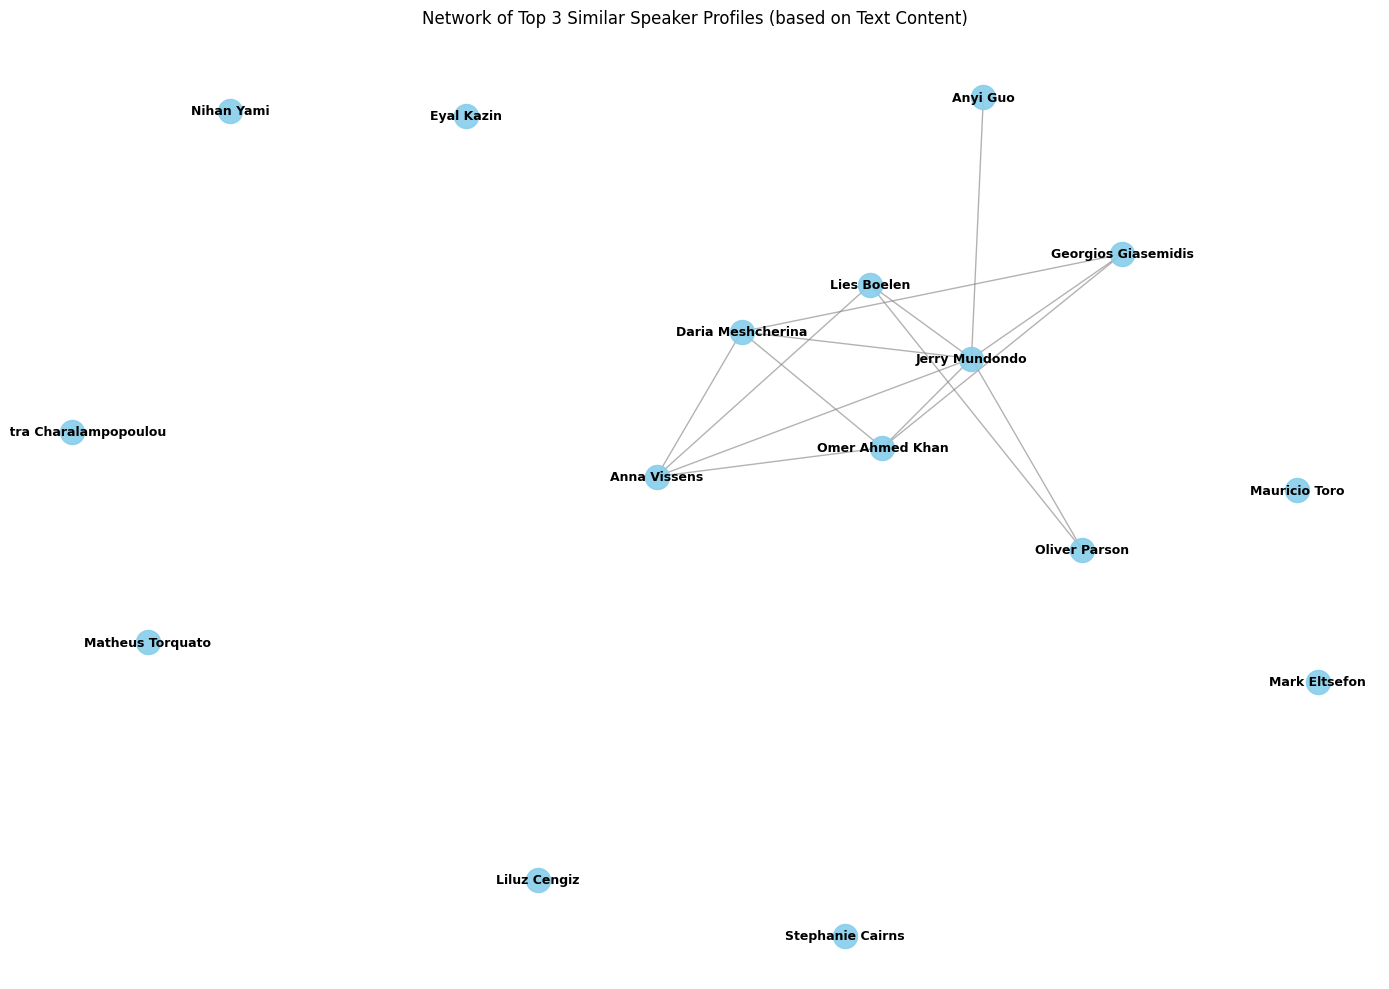

Network diagram displayed.


In [ ]:
!pip install networkx # Ensure networkx library is installed

import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns # For potentially styling the plot

# Assume data_science_roles_df is available
# Assume cosine_sim_matrix was calculated in the previous step.
# Assume 'Speaker Name' is a column in data_science_roles_df for node labels.

# --- Configuration ---
num_examples_to_show = 5 # Number of speakers to find top similar profiles for
num_top_similar = 3 # Number of top similar profiles to connect for each example speaker
# --- End Configuration ---

# Ensure cosine_sim_matrix and data_science_roles_df are available from previous steps
if 'cosine_sim_matrix' not in locals() or cosine_sim_matrix is None:
    print("Error: 'cosine_sim_matrix' not found. Please run the text vectorization and similarity calculation step first.")
elif data_science_roles_df is None or data_science_roles_df.empty:
     print("Error: 'data_science_roles_df' is not available or is empty.")
else:
    print(f"\n--- Creating Network Diagram for Top {num_top_similar} Similar Profiles ---")

    # --- Step 1: Build the Graph ---
    G = nx.Graph()

    # Add nodes (speakers) to the graph
    # Use the index of the DataFrame as node identifiers
    # Store speaker names as node attributes for labels
    if 'Speaker Name' in data_science_roles_df.columns:
        node_labels = data_science_roles_df['Speaker Name'].tolist()
    else:
        node_labels = [f"Speaker {i+1}" for i in range(len(data_science_roles_df))]
        print("Warning: 'Speaker Name' column not found. Using 'Speaker X' as node labels.")

    # Add all speakers as nodes first
    for i in range(len(data_science_roles_df)):
        G.add_node(i, label=node_labels[i])


    # Add edges based on top similarity for the first 'num_examples_to_show' speakers
    print(f"Adding edges for the top {num_top_similar} similar profiles for the first {num_examples_to_show} speakers...")

    speakers_to_process = range(min(num_examples_to_show, len(data_science_roles_df)))

    for i in speakers_to_process:
        # Get the similarity scores for speaker i with all other speakers
        sim_scores = list(enumerate(cosine_sim_matrix[i]))

        # Sort the scores in descending order (excluding similarity with itself)
        # Use a small epsilon to handle floating point comparisons for excluding self-similarity
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the indices and scores of the top 'num_top_similar' most similar profiles
        # after excluding the speaker themselves (score ~1.0)
        top_similar_indices = [
            (j, score) for j, score in sim_scores_sorted
            if i != j # Ensure we are not connecting a node to itself
        ][:num_top_similar] # Take only the top 'num_top_similar' results


        # Add edges between speaker i and their top similar profiles
        for j, score in top_similar_indices:
            # Add edge with the similarity score as a weight (optional, but good practice)
            # We only add an edge if it doesn't already exist (Graph handles this).
            G.add_edge(i, j, weight=score)
            # print(f"  Adding edge: {node_labels[i]} --({score:.4f})-- {node_labels[j]}") # Optional debug print


    print("Graph creation complete.")

    # --- Step 2: Draw the Network Diagram ---
    print("\nDrawing network diagram...")

    plt.figure(figsize=(14, 10)) # Adjust figure size as needed

    # Choose a layout algorithm (spring layout is common for visualizing relationships)
    # k controls optimal distance between nodes. Adjust if nodes are too crowded or too far apart.
    pos = nx.spring_layout(G, k=0.5, seed=42) # Add seed for reproducible layout

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.9)

    # Draw the edges
    # You could color edges by weight or use different styles if needed
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.6, edge_color='gray')

    # Draw the labels (speaker names)
    # Adjust textpos to position labels relative to nodes
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=9, font_weight='bold')

    plt.title(f'Network of Top {num_top_similar} Similar Speaker Profiles (based on Text Content)')
    plt.axis('off') # Hide the axes
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

    print("Network diagram displayed.")

    # --- Interpretation ---
    # - Nodes are speakers.
    # - Edges connect speakers who are in the top N most similar profiles
    #   of one of the first few speakers we selected.
    # - Look for groups of nodes that are more densely connected – these might
    #   represent speakers with very similar profile text content.
    # - Note that this graph only shows connections *from* the first few speakers *to* their top similar profiles.
    #   It doesn't show *all* top N relationships across the entire dataset unless you modify the edge creation loop.

In [ ]:
!pip install scikit-learn # Ensure scikit-learn is installed

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer # Already used, import again for clarity
# Assuming tfidf_matrix and vectorizer are available from the vectorization step
# Assuming data_science_roles_df is available

# --- Configuration ---
# Number of clusters you want to form. You might need to experiment with this.
# A common approach is the "Elbow Method" or Silhouette Score to find an optimal k.
num_clusters = 5 # Example: Let's try to find 5 clusters
# IMPORTANT: Replace 'YourActualJobTitleColumnName' if needed
job_title_column = 'Job Title'
# --- End Configuration ---

# Ensure tfidf_matrix, vectorizer, and data_science_roles_df are available
if 'tfidf_matrix' not in locals() or tfidf_matrix is None:
    print("Error: 'tfidf_matrix' not found. Please run the text vectorization step first.")
elif 'vectorizer' not in locals() or vectorizer is None:
     print("Error: 'vectorizer' not found. Please run the text vectorization step first.")
elif data_science_roles_df is None or data_science_roles_df.empty:
     print("Error: 'data_science_roles_df' is not available or is empty.")
else:
    print(f"\n--- Performing K-Means Clustering with {num_clusters} clusters ---")


    # --- Step 1: Apply Clustering ---
    # Using the TF-IDF matrix for clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # n_init=10 is recommended
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    print("Clustering complete.")

    # --- Step 2: Add Cluster Labels to DataFrame ---
    data_science_roles_df['Cluster'] = cluster_labels

    print("Added 'Cluster' column to data_science_roles_df.")
    print("Cluster distribution:")
    print(data_science_roles_df['Cluster'].value_counts().sort_index())

    # --- Step 3: Analyze Terms per Cluster ---
    print("\n--- Analyzing Top Terms per Cluster ---")

    # Get the feature names (terms) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Get the cluster centers from the KMeans model
    # The cluster centers are the average vectors for each cluster
    cluster_centers = kmeans.cluster_centers_

    # Iterate through each cluster to find the top terms
    print(f"Top 10 terms for each of the {num_clusters} clusters:")
    for i in range(num_clusters):
        print(f"\nCluster {i}:")
        # Get the scores for terms in this cluster center
        cluster_term_scores = cluster_centers[i]

        # Pair the scores with the feature names
        term_score_pairs = list(zip(feature_names, cluster_term_scores))

        # Sort the terms by score in descending order
        sorted_terms = sorted(term_score_pairs, key=lambda x: x[1], reverse=True)

        # Print the top N terms for this cluster
        top_n_terms = 10 # Number of top terms to display
        for term, score in sorted_terms[:top_n_terms]:
            print(f"  - {term} (Score: {score:.4f})")

    print("\nTop term analysis complete.")

    # --- Next Steps ---
    # - Review the top terms for each cluster. These terms are what primarily define the cluster based on the text data.
    # - Manually review speaker profiles within a specific cluster, *focusing on sentences/paragraphs that contain these top terms*.
    # - Consider adjusting num_clusters and re-running to see if different numbers yield more meaningful groups.
    # - Visualize the clusters on the SVD plot: Use the 'Cluster' column as the 'hue' parameter in the seaborn scatterplot.


--- Performing K-Means Clustering with 5 clusters ---
Clustering complete.
Added 'Cluster' column to data_science_roles_df.
Cluster distribution:
Cluster
0    2
1    8
2    1
3    2
4    3
Name: count, dtype: int64

--- Analyzing Top Terms per Cluster ---
Top 10 terms for each of the 5 clusters:

Cluster 0:
  - sas (Score: 0.2346)
  - artificial (Score: 0.1610)
  - degree (Score: 0.1610)
  - intelligence (Score: 0.1610)
  - ufrn (Score: 0.1600)
  - university (Score: 0.1549)
  - learning (Score: 0.1371)
  - machine (Score: 0.1371)
  - engineering (Score: 0.1247)
  - solutions (Score: 0.1108)

Cluster 1:
  - data (Score: 0.2119)
  - science (Score: 0.0933)
  - product (Score: 0.0671)
  - analytics (Score: 0.0669)
  - sports (Score: 0.0554)
  - scientist (Score: 0.0522)
  - driven (Score: 0.0506)
  - analysis (Score: 0.0494)
  - world (Score: 0.0470)
  - basketball (Score: 0.0450)

Cluster 2:
  - experimentation (Score: 0.3188)
  - attempts (Score: 0.1830)
  - boundaries (Score: 0.1830)


--- Visualizing Clusters using SVD Components (svd_1 vs svd_2) ---


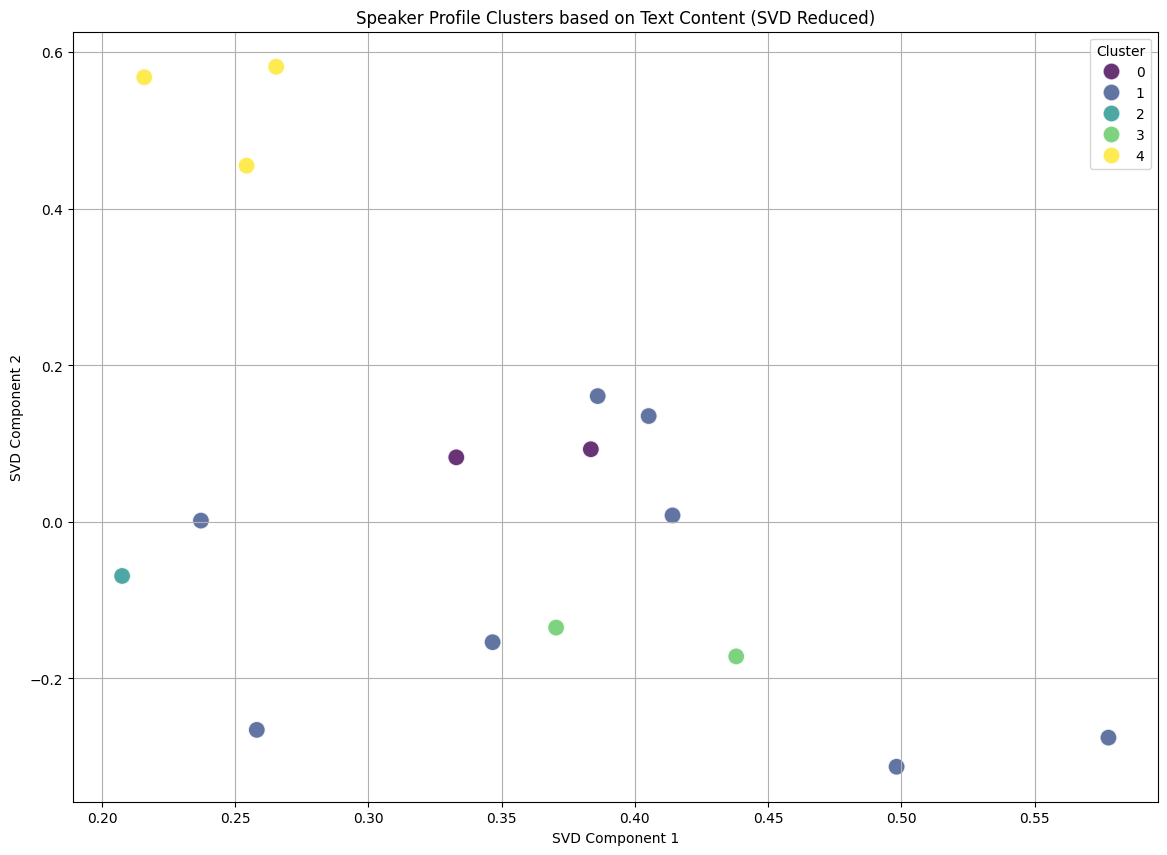

Cluster visualization complete.


In [ ]:
### MAY DELETE###


!pip install matplotlib seaborn # Ensure visualization libraries are installed

import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt
import seaborn as sns

# Assume data_science_roles_df is available and has:
# 1. SVD components added (e.g., 'svd_1', 'svd_2') from the dimensionality reduction step.
# 2. A 'Cluster' column added from the K-Means clustering step.
# Assume job_title_column and profile_text_column are defined.

# --- Configuration ---
# IMPORTANT: Ensure these match the column names used previously
job_title_column = 'YourActualJobTitleColumnName' # <-- **IMPORTANT: Replace this placeholder!**
profile_text_column = 'Speaker Profile'
# Ensure SVD components were added to the DataFrame and note their column names
svd_component_cols = [col for col in data_science_roles_df.columns if col.startswith('svd_')]
# We need at least 2 components for a 2D plot
if len(svd_component_cols) < 2:
    print("Error: Not enough SVD components found in data_science_roles_df for visualization.")
    print("Please ensure the dimensionality reduction step was run successfully.")
elif 'Cluster' not in data_science_roles_df.columns:
     print("Error: 'Cluster' column not found in data_science_roles_df.")
     print("Please ensure the clustering step was run successfully.")
else:
    svd_x = svd_component_cols[0] # First SVD component for the x-axis
    svd_y = svd_component_cols[1] # Second SVD component for the y-axis

    print(f"\n--- Visualizing Clusters using SVD Components ({svd_x} vs {svd_y}) ---")

    # --- Create a Scatter Plot, colored by Cluster ---
    plt.figure(figsize=(14, 10)) # Adjust figure size as needed

    # Use seaborn's scatterplot with the 'hue' parameter set to 'Cluster'
    # This will automatically assign a different color to each cluster label.
    sns.scatterplot(
        data=data_science_roles_df,
        x=svd_x,
        y=svd_y,
        hue='Cluster',         # Color points by their cluster label
        palette='viridis',     # Choose a color palette (many options like 'viridis', 'plasma', 'tab10')
        legend='full',         # Show the legend for clusters
        alpha=0.8,             # Make points slightly transparent
        s=150                  # Adjust point size
    )

    plt.title('Speaker Profile Clusters based on Text Content (SVD Reduced)')
    plt.xlabel(f'SVD Component 1')
    plt.ylabel(f'SVD Component 2')
    plt.grid(True)

    # Optional: Add annotations for a few points (can be noisy)
    # num_annotations = 0 # Set to > 0 to annotate points
    # if 'Speaker Name' in data_science_roles_df.columns and num_annotations > 0:
    #     print(f"Adding annotations for the first {num_annotations} points...")
    #     for i in range(min(num_annotations, len(data_science_roles_df))):
    #         plt.annotate(
    #             data_science_roles_df.iloc[i]['Speaker Name'], # Use Speaker Name as label
    #             (data_science_roles_df.iloc[i][svd_x], data_science_roles_df.iloc[i][svd_y]),
    #             textcoords="offset points", xytext=(5,5), ha='left', fontsize=8
    #         )


    plt.show()

    print("Cluster visualization complete.")

# --- Interpretation ---
# - Examine the plot. Are the points of the same color (cluster) generally grouped together?
# - Do different colors occupy distinct regions of the plot?
# - Overlapping clusters might indicate that the distinction based on text content isn't strong,
#   or that the first two SVD components don't fully capture the cluster separation.
# - Consider trying a different number of clusters in the previous step if the visualization
#   doesn't show meaningful separation.
# - Remember that SVD (and t-SNE/UMAP) is a projection; some separation in higher dimensions
#   might be lost in the 2D view.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy model 'en_core_web_sm' loaded successfully.

--- Extracting Named Entities from 'Speaker Profile' ---
Processing 16 documents...
Relevant entity extraction complete.
First 5 rows of the new 'Relevant Extracted Entities' column:
2     [wpp, imperial college, data science, choreogr...
3                                              [sports]
6     [lse’s, bbc, natural language processing, data...
10    [ml, universal music group, daria, the data sc...
12    [the university of oxford, theoretical physics...
Name: Relevant Extracted Entities, dtype: object

--- Analyzing Relev

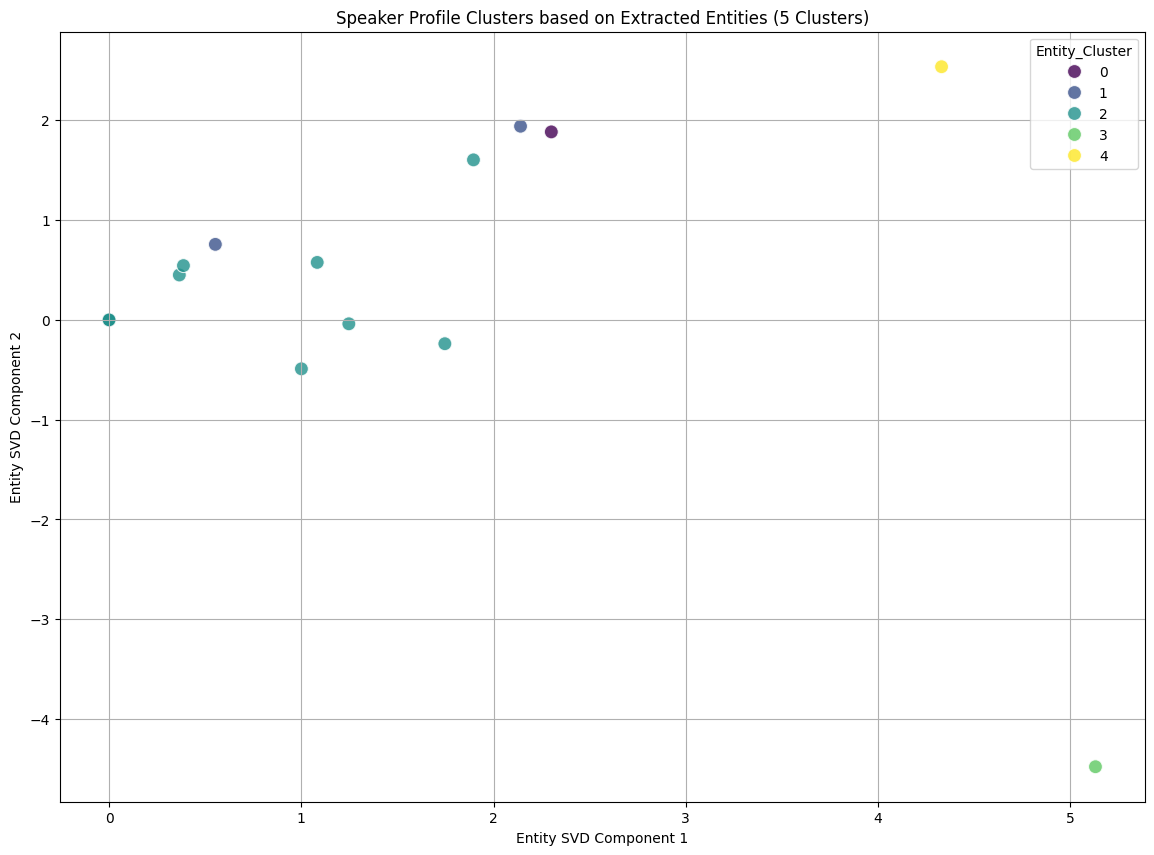

Entity Cluster visualization complete.


In [ ]:
!pip install spacy # Ensure spaCy is installed
!python -m spacy download en_core_web_sm # Download a small English model (if you haven't already)

import pandas as pd
import spacy
import collections # To count extracted entities
from sklearn.feature_extraction.text import CountVectorizer # We might use this later
from sklearn.cluster import KMeans # For clustering based on entities

# Assume data_science_roles_df is available and has the 'Speaker Profile' column with text content.
# Ensure you have run the previous steps to create data_science_roles_df.

# --- Configuration ---
profile_text_column = 'Speaker Profile' # Column containing the speaker profile text
# Define NER labels that might indicate relevant entities like organizations, products, etc.
# You might need to refine this list based on what spaCy extracts from your specific text.
relevant_ner_labels = ['ORG', 'PRODUCT', 'NORP', 'FAC', 'LOC', 'GPE', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE'] # Common relevant labels
# You might also look for specific patterns or a predefined list of data science terms
# For now, let's focus on standard NER labels that could capture tech/orgs/frameworks.
# --- End Configuration ---

# Load a spaCy English language model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Please ensure you run:")
    print("!python -m spacy download en_core_web_sm")
    print("Skipping entity extraction.")
    nlp = None # Set nlp to None if model loading fails


if nlp and profile_text_column in data_science_roles_df.columns:
    print(f"\n--- Extracting Named Entities from '{profile_text_column}' ---")

    # Store extracted relevant entities (text only, lowercase) for each profile
    all_relevant_entities_text = []

    # Iterate through the text column, processing texts with spaCy
    texts_to_process = data_science_roles_df[profile_text_column].fillna('').astype(str).tolist()

    # Process texts in batches for efficiency
    print(f"Processing {len(texts_to_process)} documents...")
    # Disable pipeline components we don't need for NER to potentially speed things up
    for doc in nlp.pipe(texts_to_process, disable=["parser", "tagger", "attribute_ruler", "lemmatizer"], batch_size=50):
        profile_entities_text = []

        # Extract entities with relevant labels
        for ent in doc.ents:
            if ent.label_ in relevant_ner_labels:
                 # Convert entity text to lowercase and add to the list for this profile
                 profile_entities_text.append(ent.text.lower())

        # Add the list of entities (deduplicated) for this profile
        all_relevant_entities_text.append(list(set(profile_entities_text)))


    # Add the extracted relevant entities list as a new column
    # This column will contain a list of strings for each speaker
    data_science_roles_df['Relevant Extracted Entities'] = all_relevant_entities_text

    print("Relevant entity extraction complete.")
    print("First 5 rows of the new 'Relevant Extracted Entities' column:")
    print(data_science_roles_df['Relevant Extracted Entities'].head())


    # --- Analyze Extracted Entities ---
    print("\n--- Analyzing Relevant Extracted Entities ---")

    # Flatten the list of lists to count overall entity frequencies
    flat_relevant_entities = [item for sublist in all_relevant_entities_text for item in sublist]
    relevant_entity_counts = collections.Counter(flat_relevant_entities)

    print(f"\nTop 30 most common relevant extracted entities ({len(relevant_entity_counts)} unique entities):")
    # Filter out single characters or very short strings that might be noise
    top_entities = [(term, count) for term, count in relevant_entity_counts.most_common(50) if len(term) > 2]
    for term, count in top_entities[:30]:
         print(f"- {term}: {count}")


    # --- Next Steps based on Relevant Extracted Entities ---
    # Now that you have a list of relevant entities (like orgs, products, places, etc.)
    # mentioned in each profile in the 'Relevant Extracted Entities' column,
    # you can use this list as a new representation for clustering or analysis.

    # 1. Create a new vector representation based ONLY on these entities.
    #    A CountVectorizer or TfidfVectorizer can be used, but it should process
    #    the *list of entities* for each profile, not the raw text.
    #    One way is to join the list of entities into a single string for each profile
    #    and then apply the vectorizer.

    print("\n--- Preparing for Vectorization based on Extracted Entities ---")
    # Join the list of entities for each profile into a single string, space-separated
    entity_texts_for_vectorization = [" ".join(entities) for entities in data_science_roles_df['Relevant Extracted Entities']]

    # 2. Vectorize the entity strings
    entity_vectorizer = CountVectorizer() # Using CountVectorizer - presence/frequency of entities
    # You could also use TfidfVectorizer if you want to weight rarer entities higher
    # entity_vectorizer = TfidfVectorizer()

    print("Fitting CountVectorizer to extracted entities...")
    entity_matrix = entity_vectorizer.fit_transform(entity_texts_for_vectorization)

    print("Entity vectorization complete.")
    print(f"Shape of the entity matrix: {entity_matrix.shape}")
    print(f"Number of unique relevant entities found: {entity_matrix.shape[1]}")

    # Optional: Inspect the learned entity vocabulary
    # print("\nFirst 50 entity features:")
    # print(entity_vectorizer.get_feature_names_out()[:50])


    # 3. Re-cluster using the new entity matrix.
    # Use a smaller number of clusters initially, as the feature space is different.
    num_entity_clusters = 5 # Example: Try 5 clusters based on entities

    if entity_matrix.shape[0] > num_entity_clusters: # Ensure we have enough samples for clustering
        print(f"\n--- Performing K-Means Clustering based on Extracted Entities ({num_entity_clusters} clusters) ---")
        kmeans_entities = KMeans(n_clusters=num_entity_clusters, random_state=42, n_init=10)
        entity_cluster_labels = kmeans_entities.fit_predict(entity_matrix)

        data_science_roles_df['Entity_Cluster'] = entity_cluster_labels

        print("Clustering on extracted entities complete.")
        print("Entity Cluster distribution:")
        print(data_science_roles_df['Entity_Cluster'].value_counts().sort_index())

        # 4. Analyze Top Entities per Cluster
        print("\n--- Analyzing Top Entities per Entity Cluster ---")
        entity_feature_names = entity_vectorizer.get_feature_names_out()
        entity_cluster_centers = kmeans_entities.cluster_centers_
        num_top_entities_per_cluster = 10

        for i in range(num_entity_clusters):
            print(f"\nEntity Cluster {i}:")
            cluster_entity_scores = entity_cluster_centers[i]
            entity_score_pairs = list(zip(entity_feature_names, cluster_entity_scores))
            sorted_entities = sorted(entity_score_pairs, key=lambda x: x[1], reverse=True)

            for term, score in sorted_entities[:num_top_entities_per_cluster]:
                print(f"  - {term} (Score: {score:.4f})")

        print("\nTop entity analysis per cluster complete.")


        # 5. Visualize Entity Clusters (Optional)
        # You can't directly use the SVD components from the *previous* full text analysis.
        # You would need to apply dimensionality reduction (like PCA or TruncatedSVD)
        # specifically to the *entity_matrix* to visualize these new clusters.

        # Example: Reduce entity_matrix to 2 components for visualization
        from sklearn.decomposition import TruncatedSVD as EntitySVD # Alias to avoid name conflict

        if entity_matrix.shape[1] >= 2: # Need at least 2 features for 2D SVD
            print("\n--- Visualizing Entity Clusters (SVD on Entity Matrix) ---")
            entity_svd = EntitySVD(n_components=2, random_state=42)
            entity_reduced = entity_svd.fit_transform(entity_matrix)

            data_science_roles_df['entity_svd_1'] = entity_reduced[:, 0]
            data_science_roles_df['entity_svd_2'] = entity_reduced[:, 1]

            plt.figure(figsize=(14, 10))
            sns.scatterplot(
                data=data_science_roles_df,
                x='entity_svd_1',
                y='entity_svd_2',
                hue='Entity_Cluster',
                palette='viridis',
                legend='full',
                alpha=0.8,
                s=100 # Adjust point size
            )
            plt.title(f'Speaker Profile Clusters based on Extracted Entities ({num_entity_clusters} Clusters)')
            plt.xlabel('Entity SVD Component 1')
            plt.ylabel('Entity SVD Component 2')
            plt.grid(True)
            plt.show()
            print("Entity Cluster visualization complete.")
        else:
             print("Cannot perform SVD visualization on entity matrix (fewer than 2 unique entities).")


    else:
        print(f"Cannot perform K-Means clustering with {num_entity_clusters} clusters, as there are only {entity_matrix.shape[0]} samples.")


else:
    print("Skipping entity-based analysis due to missing spaCy model or text column.")

Looking at the code flow we've been building:

Setup/Imports
Scraping/Initial DF creation
LinkedIn Scraping (Apify) -> df_companies
Filtering -> data_science_roles_df
TF-IDF Vectorization -> tfidf_matrix, vectorizer
SVD/Similarity -> tfidf_reduced, cosine_sim_matrix
Clustering -> cluster_labels -> 'Cluster' column
Visualization (SVD Plot)
Clustering (NMF) -> nmf_matrix, nmf_model, cluster_labels_nmf -> 'NMF_Cluster' column
Visualization (NMF Plot)

In [ ]:
# Very simplified NMF cell for debugging syntax error
# Ensure tfidf_matrix, vectorizer, and data_science_roles_df exist from previous cells

if 'tfidf_matrix' not in locals() or tfidf_matrix is None:
    print("Check 1 failed.")
elif 'vectorizer' not in locals() or vectorizer is None:
     print("Check 2 failed.")
elif data_science_roles_df is None or data_science_roles_df.empty:
     print("Check 3 failed.")
else:
    print("All checks passed. NMF code would go here.")
    # Add just the NMF model fitting line below this print to test further
    # from sklearn.decomposition import NMF
    # nmf_model = NMF(n_components=5, random_state=42, init='nndsvda', max_iter=100)
    # nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
    # print("NMF fit completed.")


# This is the final else block for the initial checks for required data
# This seems like a duplicate else block and should be removed
# else:
#      print("Skipping NMF analysis due to missing required data from previous steps.")

All checks passed. NMF code would go here.


In [ ]:
!pip install scikit-learn # Ensure scikit-learn is installed

import pandas as pd
import numpy as np
from sklearn.decomposition import NMF # Import NMF
from sklearn.feature_extraction.text import TfidfVectorizer # Assuming this is available
from sklearn.cluster import KMeans # Assuming this might be used later or was used previously

# Assume tfidf_matrix and vectorizer are available from the vectorization step
# Assume data_science_roles_df is available

# --- Configuration for NMF ---
# Number of topics you want NMF to identify. Experiment with this value.
num_topics = 5 # Example: Let's try to find 10 topics
# --- End Configuration ---

# Ensure tfidf_matrix, vectorizer, and data_science_roles_df are available
if 'tfidf_matrix' not in locals() or tfidf_matrix is None:
    print("Error: 'tfidf_matrix' not found. Please run the text vectorization step first.")
elif 'vectorizer' not in locals() or vectorizer is None:
     print("Error: 'vectorizer' not found. Please run the text vectorization step first.")
elif data_science_roles_df is None or data_science_roles_df.empty:
     print("Error: 'data_science_roles_df' is not available or is empty.")
else:
    print(f"\n--- Performing Non-negative Matrix Factorization (NMF) for Topic Modeling with {num_topics} topics ---")

    # --- Step 1: Apply NMF ---
    # Using the TF-IDF matrix for NMF
    # init='nndsvda' is often recommended for sparse matrices like TF-IDF
    # max_iter can be increased if convergence warnings occur
    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda', max_iter=200)
    # Fit the model and transform the data
    nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

    print("NMF factorization complete.")
    print(f"Shape of NMF matrix (documents x topics): {nmf_matrix.shape}")

    # --- Step 2: Analyze Topics ---
    print("\n--- Analyzing Top Terms per Topic ---")

    # Get the feature names (terms) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # The components_ attribute of the NMF model gives us the topic-term distribution
    # Each row corresponds to a topic, and each column corresponds to a term (feature_name)
    topic_term_matrix = nmf_model.components_

    # Function to print the top terms for each topic
    def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            # Get the indices of the top terms for this topic
            top_terms_indices = topic.argsort()[:-n_top_words - 1:-1]
            # Get the actual terms using the indices and feature names
            top_terms = [feature_names[i] for i in top_terms_indices]
            # Get the scores/weights for these top terms
            top_scores = [topic[i] for i in top_terms_indices]

            print(f"Topic #{topic_idx + 1}:")
            # Print terms and their scores
            for term, score in zip(top_terms, top_scores):
                 print(f"  - {term} (Score: {score:.4f})")

    num_top_words_to_display = 5 # How many top words to show for each topic
    print_top_words(nmf_model, feature_names, num_top_words_to_display)

    print("\nTopic analysis complete.")


    # --- Step 3: Assign Dominant Topic to Each Document (Optional) ---
    # Each row in nmf_matrix represents a document's topic distribution.
    # We can find the topic with the highest score for each document.
    print("\n--- Assigning Dominant Topic to Each Speaker Profile ---")
    dominant_topic = nmf_matrix.argmax(axis=1)
    data_science_roles_df['Dominant_NMF_Topic'] = dominant_topic

    print("Dominant NMF Topic assigned to data_science_roles_df.")
    print("Dominant Topic distribution:")
    print(data_science_roles_df['Dominant_NMF_Topic'].value_counts().sort_index())


    # --- Next Steps ---
    # - Review the top terms for each topic. Based on these terms, you can try to
    #   interpret what each "topic" represents (e.g., a focus area, a methodology).
    # - The 'nmf_matrix' contains the topic scores for each document. You can use
    #   this matrix as a new feature representation for downstream tasks like clustering
    #   or visualization, similar to how you used the SVD components.
    # - The 'Dominant_NMF_Topic' column can be used to group or filter your data.
    # - Consider trying a different number of topics (n_components) and re-running
    #   to see if it yields more interpretable topics.


--- Performing Non-negative Matrix Factorization (NMF) for Topic Modeling with 5 topics ---
NMF factorization complete.
Shape of NMF matrix (documents x topics): (16, 5)

--- Analyzing Top Terms per Topic ---
Topic #1:
  - data (Score: 0.7116)
  - science (Score: 0.3335)
  - analytics (Score: 0.3199)
  - sports (Score: 0.2569)
  - applications (Score: 0.2512)
Topic #2:
  - ai (Score: 0.5985)
  - ml (Score: 0.2269)
  - awards (Score: 0.2233)
  - startup (Score: 0.1898)
  - responsible (Score: 0.1855)
Topic #3:
  - world (Score: 0.2697)
  - wpp (Score: 0.1736)
  - bespoke (Score: 0.1736)
  - biomedical (Score: 0.1736)
  - college (Score: 0.1736)
Topic #4:
  - product (Score: 0.3930)
  - experimentation (Score: 0.3113)
  - data (Score: 0.2565)
  - decisions (Score: 0.1920)
  - driven (Score: 0.1558)
Topic #5:
  - sas (Score: 0.3335)
  - degree (Score: 0.2276)
  - intelligence (Score: 0.2276)
  - artificial (Score: 0.2276)
  - university (Score: 0.2269)

Topic analysis complete.

--- Assi

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
